# Supplementary code

Here are collected most of the trial cells and the code used to generate figures.

In [2]:
import pandas as pd
import numpy as np
import folium
import geocoder

neighborhoods_venues_sorted = pd.read_csv('Data/neighborhoods_venues_sorted.csv')
neighborhoods_venues_sorted.drop('Unnamed: 0', axis=1, inplace=True)
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,"1000, Lausanne",Swiss Restaurant,French Restaurant,IT Services,Pizza Place,Athletics & Sports,Event Space,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,2,46.5534,6.6971
1,"1001, Lausanne",Bar,French Restaurant,Burger Joint,Japanese Restaurant,Italian Restaurant,Plaza,Chinese Restaurant,Restaurant,Pizza Place,Wine Bar,6,46.5224,6.6303
2,"1002, Lausanne",Bar,Italian Restaurant,Thai Restaurant,Park,Sandwich Place,Gastropub,Tea Room,Boutique,Coffee Shop,Pool,6,46.5195,6.6322
3,"1004, Lausanne",Grocery Store,Supermarket,Bus Stop,Bar,Italian Restaurant,Gas Station,Theater,Sushi Restaurant,Chinese Restaurant,Steakhouse,6,46.5285,6.6187
4,"1005, Lausanne",Italian Restaurant,Supermarket,Hotel,Park,Coffee Shop,Café,Burger Joint,English Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,6,46.5199,6.6425


In [42]:
cities = ['Z\xfcrich', 'Gen\xE8ve', 'Basel', 'Lausanne', 'Bern', 'Winterthur', 'Luzern', 'St. Gallen', 'Lugano', 'Biel/Bienne']

In [ ]:
for i in cities:
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google(i)
        lat_lng_coords = g.latlng

    # create map
    map_clusters = folium.Map(location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=12, tiles='CartoDB positron')

    manual_c = ['#FFE318','#57C2EA', '#13b79c','#000000', '#faf200','#9F3EA0', '#265dca', '#CF3838','#A1A9AD','#4C8949','#7718FF']

    # add markers to the map
    df_ct = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'].str.contains(i)]
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_ct['Latitude'], df_ct['Longitude'], df_ct['Neighborhood'], df_ct['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=manual_c[cluster-1],
            fill=True,
            fill_color=manual_c[cluster-1],
            fill_opacity=1).add_to(map_clusters)

    map_clusters.save('Outputs/'+i)

In [25]:
ch_restaurants = pd.read_csv('Data/ch_restaurants.csv')

In [26]:
ch_restaurants_subset = ch_restaurants[ch_restaurants['Rating'].notnull()].copy()
ch_restaurants_subset.shape

(420, 12)

In [27]:
ch_restaurants_subset['Tier'].fillna(2, inplace=True)
ch_restaurants_subset.isnull().sum().to_frame('% of data has NaN').sort_values(by='% of data has NaN', ascending=False)

,% of data has NaN
Unnamed: 0,0
Neighborhood,0
Latitude,0
Longitude,0
Venue,0
Venue Category,0
Venue id,0
Venue Latitude,0
Venue Longitude,0
Rating,0


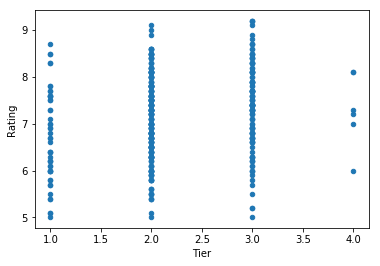

In [8]:
ch_model = ch_restaurants_subset.reset_index()[['Rating', 'Tier', 'Likes']]
%matplotlib inline
ch_model.plot(kind='scatter', x='Tier', y='Rating');

In [9]:
ch_big10_cities = ['Z\xfcrich', 'Gen\xE8ve', 'Basel', 'Lausanne', 'Bern', 'Winterthur', 'Luzern', 'St. Gallen', 'Lugano', 'Biel/Bienne']

city_centers = {}

for i in ch_big10_cities:
    
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google(i + ' Switzerland')
        lat_lng_coords = g.latlng
    city_centers[i] = [lat_lng_coords[0], lat_lng_coords[1]]    

pd.DataFrame.from_dict(city_centers)

,Zürich,Genève,Basel,Lausanne,Bern,Winterthur,Luzern,St. Gallen,Lugano,Biel/Bienne
0,47.376887,46.204391,47.559599,46.519653,46.947974,47.498820,47.050168,47.424482,46.003678,47.136778
1,8.541694,6.143158,7.588576,6.632273,7.447447,8.723689,8.309307,9.376717,8.951052,7.246791


In [10]:
def get_center_lat(row):
    return city_centers[row[6:]][0]
def get_center_lng(row):
    return city_centers[row[6:]][1]

ch_restaurants_subset['City Center Latitude'] = ch_restaurants_subset['Neighborhood'].apply(get_center_lat)
ch_restaurants_subset['City Center Longitude'] = ch_restaurants_subset['Neighborhood'].apply(get_center_lng)

In [11]:
def get_distance(x1,y1,x2,y2):
    return geocoder.distance([x1,y1], [x2,y2])

In [12]:
ch_restaurants_subset['Distance'] = np.vectorize(get_distance)(ch_restaurants_subset['Venue Latitude'], ch_restaurants_subset['Venue Longitude'],ch_restaurants_subset['City Center Latitude'],ch_restaurants_subset['City Center Longitude'])

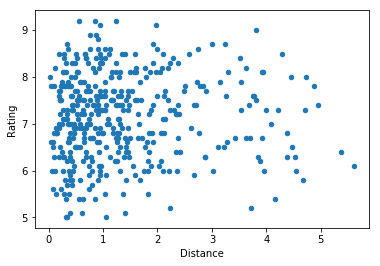

In [14]:
ch_restaurants_subset.plot(kind='scatter', x='Distance', y='Rating');

In [15]:
x_data = ch_model['Likes']
y_data = ch_model['Rating']

In [16]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 63
number of training samples: 357


In [17]:
x_test = x_test[1:]
y_test = y_test[1:]

In [18]:
from scipy.optimize import curve_fit

x = x_train.values
y = y_train.values

def test_func(x, a, b, c):
    return -0.5*(((1-c)/np.pi)*np.arctan(a*(x-b))) + c/1.3
    
init_vals = [1, 8, 8.9]
params, covar = curve_fit(test_func, x, y, method='dogbox', p0=init_vals, bounds=([0., 0.,7.],[1., 15.,10.]))
print(params)

[0.11336578 4.02425551 8.18411096]


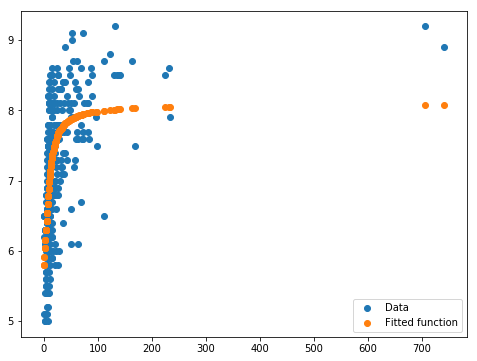

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.scatter(x, test_func(x, params[0], params[1], params[2]), label='Fitted function')
plt.legend(loc='best')
plt.show()

0.2413835423806151

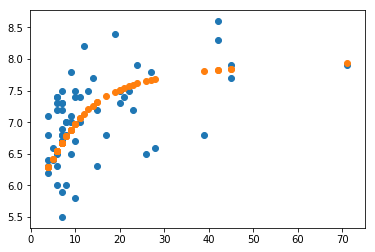

In [21]:
y_true = y_test.values
y_hat = test_func(x_test.values, params[0], params[1], params[2])
plt.scatter(x_test.values, y_true)
plt.scatter(x_test.values, y_hat)
(1 - ((y_true - y_hat) ** 2).sum()/((y_true - y_true.mean()) ** 2).sum())

In [22]:
def DistributionPlot(RedFunction,BlueFunction,RedName,BlueName,Title ):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)

    plt.show()
    plt.close()

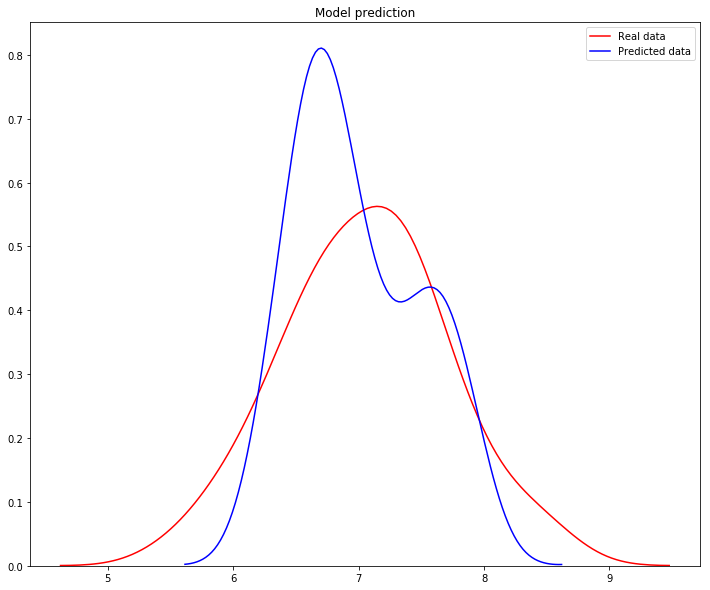

In [24]:
import seaborn as sns
DistributionPlot(y_true, y_hat, 'Real data', 'Predicted data', 'Model prediction')

In [29]:
ch_restaurants_subset.describe()

,Unnamed: 0,Latitude,Longitude,Venue Latitude,Venue Longitude,Rating,Tier,Likes
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,24.452381,47.130139,7.888432,47.130797,7.887895,7.158571,2.207143,29.159524
std,15.091451,0.436483,0.894854,0.436949,0.895231,0.900754,0.653572,72.852850
min,0.000000,45.970100,6.102800,45.972890,6.094469,5.000000,1.000000,0.000000
25%,10.750000,46.947000,7.440400,46.948575,7.444179,6.500000,2.000000,7.000000
50%,24.000000,47.366700,8.306000,47.368647,8.306948,7.200000,2.000000,12.000000
75%,38.000000,47.399000,8.543200,47.402055,8.539775,7.800000,3.000000,27.000000
max,49.000000,47.576100,9.414100,47.574600,9.412833,9.200000,4.000000,943.000000


In [47]:
cities = ['Z\xfcrich', 'Gen\xE8ve', 'Basel', 'Lausanne', 'Bern', 'Winterthur', 'Luzern', 'St. Gallen', 'Lugano', 'Biel']

df = ch_restaurants_subset[['Neighborhood','Venue Latitude', 'Venue Longitude','Venue', 'Likes']]
import geocoder

for i in cities:
    
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google(i+', Switzerland')
        lat_lng_coords = g.latlng

    map_ch = folium.Map(location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=13, tiles='CartoDB positron')
    df_ct = df[df['Neighborhood'].str.contains(i)]
    for lat, lng, v, l in zip(df_ct['Venue Latitude'], df_ct['Venue Longitude'], df_ct['Venue'], df_ct['Likes']):
        label = '{}: {} likes'.format(v, int(l))
        label = folium.Popup(label, parse_html=True)

        if l < 5:
            l = 5

        folium.CircleMarker(
            [lat, lng],
            radius=np.sqrt(l/np.pi),
            popup=label,
            color='#9F3EA0',
            fill=True,
            fill_color='#9F3EA0',
            fill_opacity=1).add_to(map_ch)  

    map_ch.save('Outputs/Restaurants_'+i)